<a href="https://colab.research.google.com/github/francisbonheur/alyra_projet_deep_learning/blob/main/ML_detection_valeur_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning : prédiction de la valeur humaine "famille et tradition"

A partir des données issues de l'European Social Survey.  
Dataset :  
 - [European social survey dataset generator](https://ess.sikt.no/en/data-builder/?tab=download&variables=0.8+1.0.30_40_58-60_73-76+2.0.64_65_68_76+3.1_87+4.0.8_22_30_31_47_74_76_90-93_132+5.4_6_8_12_16+9.25_28&seriesVersion=920&rounds=0+1+2+3+4+5+6+7+8+9+10+11)

## Chargement des frameworks python

In [41]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from rpy2.robjects.packages import importr

from sklearn.model_selection import train_test_split

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Chargement du dataset

In [42]:
# Lecture du dataset (fichier CSV)
# L'index est composé des colonnes qui permettent d'identifier de façon unique l'individu
# 0 : name - Title of dataset
# 1 : essround - ESS round
# 2 : edition - Edition
# 3 : proddate - Production date
# 4 : idno - Respondent's identification number
# 5 : cntry - Country
df = pd.read_csv('https://raw.githubusercontent.com/francisbonheur/alyra_project_machine_learning/refs/heads/main/ESSfull-20251120.csv', header=0, index_col=[0,1,2,3,4])

df = df.reset_index(drop=True)

# Vérification du nombre de doublons
print(f"Nombre de doublons : {df.index.duplicated().sum()}")

# Ces colonnes decrive le dataset et ne représentent pas des features
ess_description_columns_name = ['dweight', 'pspwght', 'pweight', 'anweight', 'prob', 'stratum', 'psu']

available_labels_names = ['ipbhprp', 'impfun', 'imptrad', 'imprich', 'impfree']

label_name = 'imptrad'

available_labels_names.remove(label_name)

# On ne conserve que les données utiles pour la prédiction
data_without_description = df.drop(columns=ess_description_columns_name, axis=1)

# On se conserve que le label à prédire "famille et tradition"
data_without_useless_labels = data_without_description.drop(columns=available_labels_names, axis=1)

data_without_useless_labels.info()


Nombre de doublons : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540671 entries, 0 to 540670
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cntry     540671 non-null  object 
 1   ppltrst   540671 non-null  int64  
 2   implvdm   114358 non-null  float64
 3   lrscale   540671 non-null  int64  
 4   polintr   540671 non-null  int64  
 5   trstlgl   540671 non-null  int64  
 6   trstplc   540671 non-null  int64  
 7   trstplt   540671 non-null  int64  
 8   imwbcnt   540671 non-null  int64  
 9   volunfp   109801 non-null  float64
 10  lrnobed   109801 non-null  float64
 11  loylead   109801 non-null  float64
 12  rlgdgr    540671 non-null  int64  
 13  rlgdnm    527156 non-null  float64
 14  sclmeet   540671 non-null  int64  
 15  wrclmch   154188 non-null  float64
 16  gndr      540671 non-null  int64  
 17  agea      540671 non-null  int64  
 18  chldhm    381351 non-null  float64
 19  domicil   540671 non-

## Nettoyage des données

### Suppression des valeurs représentant une "non réponse"
Le sondé à la possibilité de ne pas répondre au questions posées.  
La non réponse peut correpondre aux cas suivants :
- Le sondé ne souhaite pas répondre
- Le sondé ne sait pas
- La question n'est pas applicable au sondé
- Pas de réponse

Chaque cas de "non réponse" est codé de façon différente dans chaque question. Il s'agit ici de considérer tous les cas de non réponse de la même façon. C'est à dire par une valeur manquante (nan de numpy) qui fera l'object d'une imputation plus tard.

In [43]:
# Matrice des noms de colonnes et des valeurs à remplacer
missing_values_dict = {
    'polintr': [7, 8, 9],
    'rlgdgr': [77, 88, 99],
    'rlgdnm': [66,77, 88, 99],
    'sclmeet': [77, 88, 99],
    'gndr': [9],
    'agea': [999],
    'chldhm': [9], # impossible de faire la différence avec le cas "9 enfants à la maison
    'edulvla': [77, 88, 99],
    'edulvlb': [7777, 8888, 9999],
    'emplrel': [7, 8, 9],
    'isco08': [66666, 77777, 88888, 99999],
    'iscoco': [66666, 77777, 88888, 99999],
    'marital': [7, 8, 9],
    'maritala': [77, 88, 99],
    'maritalb': [77, 88, 99],
    'marsts': [66, 77, 88, 99],
    'tporgwk': [66, 77, 88, 99],
    'imptrad': [7, 8, 9],
    'impfree': [7, 8, 9],
    'imprich': [7, 8, 9],
    'ipbhprp': [7, 8, 9],
    'impfun' : [7, 8, 9],
    'ppltrst' : [77,88,99],
    'implvdm' : [77,88,99],
    'lrscale' : [77,88,99],
    'trstlgl' :  [77,88,99],
    'trstplc' : [77,88,99],
    'trstplt' : [77,88,99],
    'imwbcnt' :  [77,88,99],
    'volunfp' : [7,8,9],
    'lrnobed' : [7,8,9],
    'loylead' : [7,8,9],
    'wrclmch' : [6,7,8,9],
    'domicil' : [7,8,9]
}


data_without_no_reponse_codes = data_without_useless_labels.replace(missing_values_dict, np.nan)

for column in data_without_useless_labels.columns:
  print(f"Colonne : {column} - Cardinalité avant traitement : {len(data_without_useless_labels[column].unique())} -  Cardinalité après traitement : {len(data_without_no_reponse_codes[column].unique())}")

Colonne : cntry - Cardinalité avant traitement : 39 -  Cardinalité après traitement : 39
Colonne : ppltrst - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : implvdm - Cardinalité avant traitement : 15 -  Cardinalité après traitement : 12
Colonne : lrscale - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : polintr - Cardinalité avant traitement : 7 -  Cardinalité après traitement : 5
Colonne : trstlgl - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : trstplc - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : trstplt - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : imwbcnt - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : volunfp - Cardinalité avant traitement : 6 -  Cardinalité après traitement : 3
Colonne : lrnobed - Cardinalité avant traitement : 9 -  Cardinalité après traitement : 6
Colonne

### Suppression des lignes sans label
Suppression des individus sans label (le sondé n'a pas répondu à la question)  

In [44]:
# Suppression des lignes sans label
data_no_empty_label = data_without_no_reponse_codes.dropna(subset=[label_name])

print(f"Taille du dataset avant traitement {data_without_no_reponse_codes.shape}")
print(f"Taille du dataset après traitement {data_no_empty_label.shape}")

Taille du dataset avant traitement (540671, 31)
Taille du dataset après traitement (452333, 31)


### Simplification du problème
On commence par une classification simple (binaire) quitte à complexifier le problème par la suite

In [45]:
tradition_value_sensibility_matrix = {
    label_name : {
        1: 0,
        2: 0,
        3: 0,
        4: 1,
        5: 1,
        6: 1,
    }
}

data = data_no_empty_label.replace(tradition_value_sensibility_matrix)

print(f"Classes possible : {data[label_name].unique()}")

Classes possible : [0. 1.]


### Données manquantes par lignes

In [46]:
# Calcul du pourcentage de valeurs manquantes par ligne
missing_value_min_percent = min(data.isnull().mean(axis=1) * 100)

if missing_value_min_percent > 15:
    print("Toutes les lignes ont plus de 15% de valeurs manquantes. La suppression est immossible on privilégie l'imputation")



Toutes les lignes ont plus de 15% de valeurs manquantes. La suppression est immossible on privilégie l'imputation


#### Données manquantes par colonne
On vérifier si certaines features sont trop incomplètes pour être conservés (plus de 50% de données manquantes)

In [47]:
#Calcul du pourcentage de valeurs manquantes par colonne
print("Pourcentage de valeurs manquantes par colonne :")
missing_values_percent_per_col = data.isnull().mean() * 100

# Affichage des colonnes avec plus de 50 % de valeurs manquantes
for col, percent in missing_values_percent_per_col.items():
    if percent > 50:
        print(f"{col}: {percent:.2f}%")


Pourcentage de valeurs manquantes par colonne :
implvdm: 80.24%
volunfp: 91.84%
lrnobed: 91.85%
loylead: 92.01%
wrclmch: 82.63%
edulvla: 60.60%
isco08: 56.15%
iscoco: 55.43%
marital: 82.58%
maritala: 79.12%
marsts: 69.44%


<ins>Traitement des colonnes isco08 et iscoco</ins>  
- la colonne isco08 donne la profession du sondé dans le référentiel ISCO-08
- la colonne iscoco donne la profession du sondé dans le référentiel ISCO-88  
- Les deux colonnes sont complémentaires (la même question existe dans le questionnaire du sondage sous 2 codes différents).  
  - Conversion des données de la colonne isco08 dans le référentiel ISCO-88 (Utilisation d'une fonction R [ISCO08ConveRsions](https://cran.r-project.org/web/packages/ISCO08ConveRsions/index.html) )
  - Fusion des 2 colonnes dans une nouvelle colonne "occupation"

In [48]:
# Load R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [49]:
# indicate that you're running R code
#%%R

# Install if it's your first time to run
#install.packages("ISCO08ConveRsions")

In [50]:
# Nombre de lignes avec les deux colonnes isco08 et iscoco manquantes
missing_isco08_iscoco = data[data['isco08'].isnull() & data['iscoco'].isnull()]
print(f"Nombre de lignes sans l'information de la profession (colonnes isco08 et iscoco vides) : {len(missing_isco08_iscoco)}")

# Les deux colonnes sont complémentaires, on va faire du feature engineering pour créer une nouvelle colonne 'occupation' qui regroupe les deux informations

# installation du package R ISCO08ConveRsions nécessaire : install.packages("ISCO08ConveRsions")
ISCO08ConveRsions = importr('ISCO08ConveRsions')


# Méthode conversion des code professions ISCO 08 en ISCO 88
def isco08_to_isco88(code):
    try:
        # La fonction R ne sais pas convertir le code ISCO 08 '0', on le gère nous même
        if code == '0000':
            return code

        return ISCO08ConveRsions.isco08toisco88(code)[0]
    except:
        print(f"Conversion impossible pour le code ISCO 08 : {code}")
        return np.nan

# Get ISO code as string with leading zeros
def get_code(code_as_int):
    if pd.isnull(code_as_int):
        return np.nan

    return str(code_as_int).split('.')[0].zfill(4)

data['occupation_code'] = data.apply(
    lambda row: isco08_to_isco88(get_code(row['isco08'])) if pd.notnull(row['isco08']) else get_code(row['iscoco']),
    axis=1
)

# Nombre de lignes avec la colonne occupation manquante
missing_occupation = data[data['occupation_code'].isnull()]
print(f"Nombre de lignes sans l'information de la profession après feature engineering (colonne occupation vide) : {len(missing_occupation)}")

data['occupation'] = data['occupation_code'].str[0]

data = data.drop(columns=['occupation_code', 'isco08', 'iscoco'], axis=1)


Nombre de lignes sans l'information de la profession (colonnes isco08 et iscoco vides) : 52378
Nombre de lignes sans l'information de la profession après feature engineering (colonne occupation vide) : 52378


<ins>Traitement des colonnes edulvla et edulvlb</ins>  
- la colonne edulvla donne le niveau d'étude dans le référentiel ISCED (5 niveaux)
- la collone edulvlb donne le niveau d'étude dans le référentiel ISCED (description détaillé)
- Les deux colonnes sont complémentaires
  - Conversion des données de la colonnes edulvlb dans le référentiel ISCED "simplifié" (création d'une matrice mapping à partir de la documentation)
  - Fusion des deux colonnes dans une nouvelle colonne "education"

|       |Inclassable|ISCED 0-1|ISCED 2|ISCED 3|ISCED 4|ISCED 5-6|Other|
|-------|-----------|---------|-------|-------|-------|---------|-----|
|edulvla|          0|        1|                      2|                          3|                  4|        5| 55|
|edulvlb|           |    0,113|129,212,213<br>221,222,223|229,311,312<br>313,321,322,323|412,413,421<br>422,423|510,520,610<br>620,710,720,800|5555|

In [51]:
# Nombre de lignes avec les deux colonnes edulvla et edulvla manquantes
missing_edulvla_edulvlb = data[data['edulvla'].isnull() & data['edulvlb'].isnull()]
print(f"Nombre de lignes sans l'information du niveau d'étude (colonnes edulvla et edulvlb vides) : {len(missing_edulvla_edulvlb)}")

# Affichage des valeurs uniques de la colonne edulvlb avant le mapping
print("Valeurs uniques de la colonne edulvlb avant le mapping :")
print(data['edulvlb'].unique())

education_mapping_matrix = {
    'edulvlb': {
        0: 1,
        113: 1,
        129: 2,
        212: 2,
        213: 2,
        221: 2,
        222: 2,
        223: 2,
        229: 3,
        311: 3,
        312: 3,
        313: 3,
        321: 3,
        322: 3,
        323: 3,
        412: 4,
        413: 4,
        421: 4,
        422: 4,
        423: 4,
        510: 5,
        520: 5,
        610: 5,
        620: 5,
        710: 5,
        720: 5,
        800: 5,
        5555: 55
    }
}

data = data.replace(education_mapping_matrix)

# Affichage des valeurs uniques de la colonne edulvlb après le mapping
print("Valeurs uniques de la colonne edulvlb après le mapping :")
print(data['edulvlb'].unique())

# Création de la colonne education qui regroupe les deux colonnes edulvla et edulvlb
data['education'] = data.apply(
    lambda row: row['edulvla'] if pd.notnull(row['edulvla']) else get_code(row['edulvlb']),
    axis=1
)

data = data.drop(columns=['edulvla', 'edulvlb'], axis=1)

# Nombre de lignes avec la colonne occupation manquante
missing_education = data[data['education'].isnull()]
print(f"Nombre de lignes sans l'information du niveau d'étude après feature engineering (colonne education vide) : {len(missing_education)}")



Nombre de lignes sans l'information du niveau d'étude (colonnes edulvla et edulvlb vides) : 1219
Valeurs uniques de la colonne edulvlb avant le mapping :
[  nan  323.  610.  321.  720.  313.  113.  213.  421.  222.  710.  423.
    0.  413.  800.  620.  510. 5555.  322.  520.  312.  212.  229.  422.
  129.  311.  221.  223.  412.]
Valeurs uniques de la colonne edulvlb après le mapping :
[nan  3.  5.  1.  2.  4. 55.]
Nombre de lignes sans l'information du niveau d'étude après feature engineering (colonne education vide) : 1219


<ins>Traitement des colonnes du statut marital</ins>
- Les colonnes marital, maritala, maritalb et marsts donne le statut marital du sondé aves des propositions de réponses différentes
- Les quatres colonnes sont complémentaires
  - Conversion des données des colonnes maritala, maritalb et marsts dans le référentiel de réponse de la colonne marital (création d'une matrice de correspondance des codes de status marital à partir de la documentation)
  - Fusion des quatres colonnes dans une nouvelle colonne "marital_status"

|                | marital | maritala | maritalb | marsts |
|----------------|---------|----------|----------|--------|
| Married        | 1       | 1,2      | 1,2      | 1,2    |
| Separated      | 2       | 3,4      | 3        | 3      |
| Divorced       | 3       | 5,7      | 4        | 4      |
| Widowed        | 4       | 6,8      | 5        | 5      |
| Never married  | 5       | 9        | 6        | 6      |


In [52]:
# Nombre de lignes avec les colonnes marital, maritala, maritalb et marsts manquantes
missing_marital = data[data['marital'].isnull() & data['maritala'].isnull() & data['maritalb'].isnull() & data['marsts'].isnull()]
print(f"Nombre de lignes sans l'information du statut marital (colonnes marital, maritala, maritalb et marsts vides) : {len(missing_marital)}")

print("Valeurs uniques des colonnes maritala, maritalb et marsts avant le mapping :")
print(data['maritala'].unique())
print(data['maritalb'].unique())
print(data['marsts'].unique())

marital_status_mapping_matrix = {
    'maritala' : {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 3,
        7: 3,
        6: 4,
        8: 4,
        9: 5
    },
    'maritalb' : {
        1: 1,
        2: 1,
        3: 2,
        4: 3,
        5: 4,
        6: 5,
    },
    'marsts' : {
        1: 1,
        2: 1,
        3: 2,
        4: 3,
        5: 4,
        6: 5,
    },
}

data = data.replace(marital_status_mapping_matrix)

print("Valeurs uniques des colonnes maritala, maritalb et marsts après le mapping :")
print(data['maritala'].unique())
print(data['maritalb'].unique())
print(data['marsts'].unique())

# Création de la colonne marital_status qui merge les 4 colonnes marital, maritala, maritalb et marsts
def get_marital_status(row):
    if pd.notnull(row['marital']):
        return row['marital']
    elif pd.notnull(row['maritala']):
        return row['maritala']
    elif pd.notnull(row['maritalb']):
        return row['maritalb']
    elif pd.notnull(row['marsts']):
        return row['marsts']
    else:
        return np.nan

data['marital_status'] = data.apply(
    lambda row: get_marital_status(row),
    axis=1
)

data = data.drop(columns=['marital', 'maritala', 'maritalb', 'marsts'], axis=1)

# Nombre de lignes avec la colonne occupation manquante
missing_marital_status = data[data['marital_status'].isnull()]
print(f"Nombre de lignes sans l'information du statut marital après feature engineering (colonne marital_status vide) : {len(missing_marital_status)}")



Nombre de lignes sans l'information du statut marital (colonnes marital, maritala, maritalb et marsts vides) : 10569
Valeurs uniques des colonnes maritala, maritalb et marsts avant le mapping :
[nan  9.  1.  5.  6.  3.  2.  7.  8.  4.]
[nan  6.  1.  5.  4.  3.  2.]
[nan  6.  5.  4.  3.  1.  2.]
Valeurs uniques des colonnes maritala, maritalb et marsts après le mapping :
[nan  5.  1.  3.  4.  2.]
[nan  5.  1.  4.  3.  2.]
[nan  5.  4.  3.  2.  1.]
Nombre de lignes sans l'information du statut marital après feature engineering (colonne marital_status vide) : 10569


La feature engineering réalisée ici à plusieurs avantages
- Diminution des dimensions du dataset
- Dicrétisation des données pour le statut marital et le niveau d'étude
- Perte d'information minimale (par rapport à la suppresion des valeurs manquantes sur les colonnes originales)

<ins> Suppression des colonnes avec plus de 50 % de données manquantes</ins>

In [53]:
data.isnull().mean() * 100

# Suppression des caractéristiques avec plus de 50% de valeurs manquantes
data_enough_values = data.dropna(axis=1, thresh=data.shape[0] * 0.5)

print("Colonnes conservées après suppression de celles avec plus de 50% de valeurs manquantes :")
data_enough_values.isnull().mean() * 100

Colonnes conservées après suppression de celles avec plus de 50% de valeurs manquantes :


cntry              0.000000
ppltrst            0.324982
lrscale           14.167439
polintr            0.302653
trstlgl            2.466988
trstplc            1.139868
trstplt            1.915403
imwbcnt            4.757999
rlgdgr             0.867502
rlgdnm            40.200472
sclmeet            0.519529
gndr               0.049300
agea               0.414518
chldhm            19.139660
domicil            0.202506
emplrel            1.807739
tporgwk           35.631714
imptrad            0.000000
occupation        11.579522
education          0.269492
marital_status     2.336553
dtype: float64

### Vérification de la distribution du label

Il s'agit d'équilibrer le dataset pour avoir autant d'individu sensible à la valeur humaine traité ici que d'individus non sensible.

imptrad
0.0    336484
1.0    115849
Name: count, dtype: int64


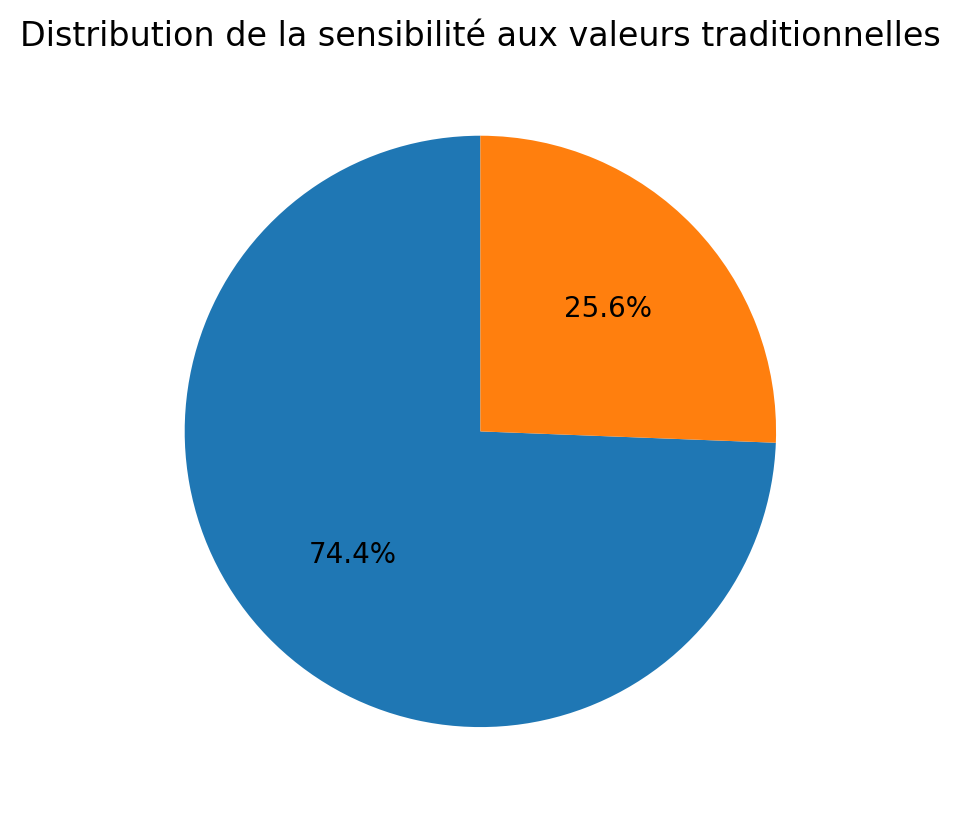

In [54]:
# 1. Distribution de la variable cible
plt.subplot()
tradition_value_sensibility = data_enough_values[label_name].value_counts()
plt.pie(tradition_value_sensibility.values, autopct='%1.1f%%',
         startangle=90)
plt.title('Distribution de la sensibilité aux valeurs traditionnelles')

print(tradition_value_sensibility)

On supprime le biais lié à la mauvaise distribution du label dans le dataset

imptrad
0.0    115849
1.0    115849
Name: count, dtype: int64
Nouvelle dimension du dataset après équilibrage : (231698, 21)


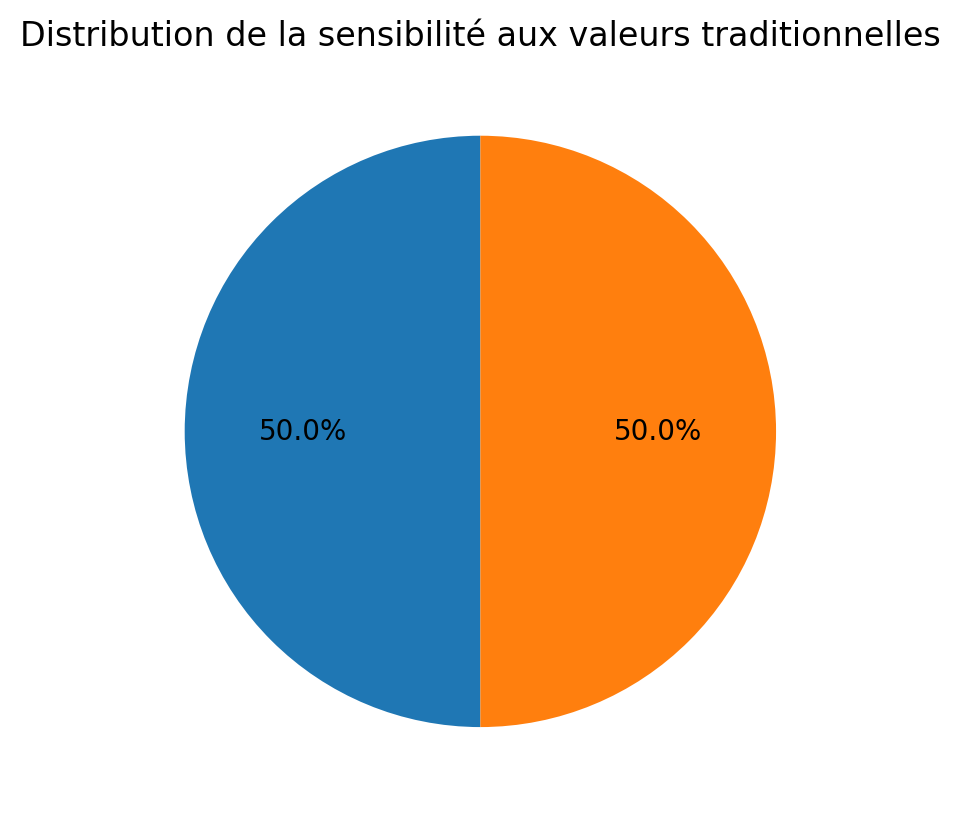

In [55]:
balanced_data = pd.DataFrame()
for value in tradition_value_sensibility.index:
    subset = data_enough_values[data_enough_values[label_name] == value].sample(n=np.min(tradition_value_sensibility), replace=True, random_state=42)
    balanced_data = pd.concat([balanced_data, subset])

tradition_value_sensibility_balanced = balanced_data[label_name].value_counts()

print(tradition_value_sensibility_balanced)


plt.pie(tradition_value_sensibility_balanced.values, autopct='%1.1f%%',
        startangle=90)
plt.title('Distribution de la sensibilité aux valeurs traditionnelles')

print(f"Nouvelle dimension du dataset après équilibrage : {balanced_data.shape}")


### Analyse descriptive

Analyse descriptive sur les features numériques pour détecter les éventuels outliers à supprimer

In [56]:
numerical_cols = ['agea', 'chldhm']

print("Analyse descriptive des données numériques")
balanced_data[numerical_cols].describe()

Analyse descriptive des données numériques


,agea,chldhm
count,230760.000000,186981.000000
mean,46.872543,1.629786
std,18.442883,0.482863
min,14.000000,1.000000
25%,32.000000,1.000000
50%,46.000000,2.000000
75%,61.000000,2.000000
max,114.000000,2.000000


Analyse descriptive des données catégorielles pour vérifier la cardinalité des features

In [57]:
print("Analyse descriptive des données catégorielles")
balanced_data.drop(numerical_cols, axis=1).astype(str).describe()


Analyse descriptive des données catégorielles


,cntry,ppltrst,lrscale,polintr,trstlgl,trstplc,trstplt,imwbcnt,rlgdgr,rlgdnm,sclmeet,gndr,domicil,emplrel,tporgwk,imptrad,occupation,education,marital_status
count,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698
unique,39,12,12,5,12,12,12,12,12,9,8,3,6,5,7,2,11,13,6
top,DE,5.0,5.0,2.0,5.0,8.0,5.0,5.0,0.0,nan,6.0,2.0,3.0,1.0,4.0,0.0,2,0003,1.0
freq,13905,45529,64836,80736,35545,40458,38449,65668,44472,109675,63871,120382,71566,178957,83312,115849,34224,54196,110872


### Matrice de corrélation

Il s'agit de vérifier la corrélation qui existe entre les différentes features et le label pour vérifier s'il est possible de simplifier le dataset.

Text(0.5, 1.0, 'correlation matrix')

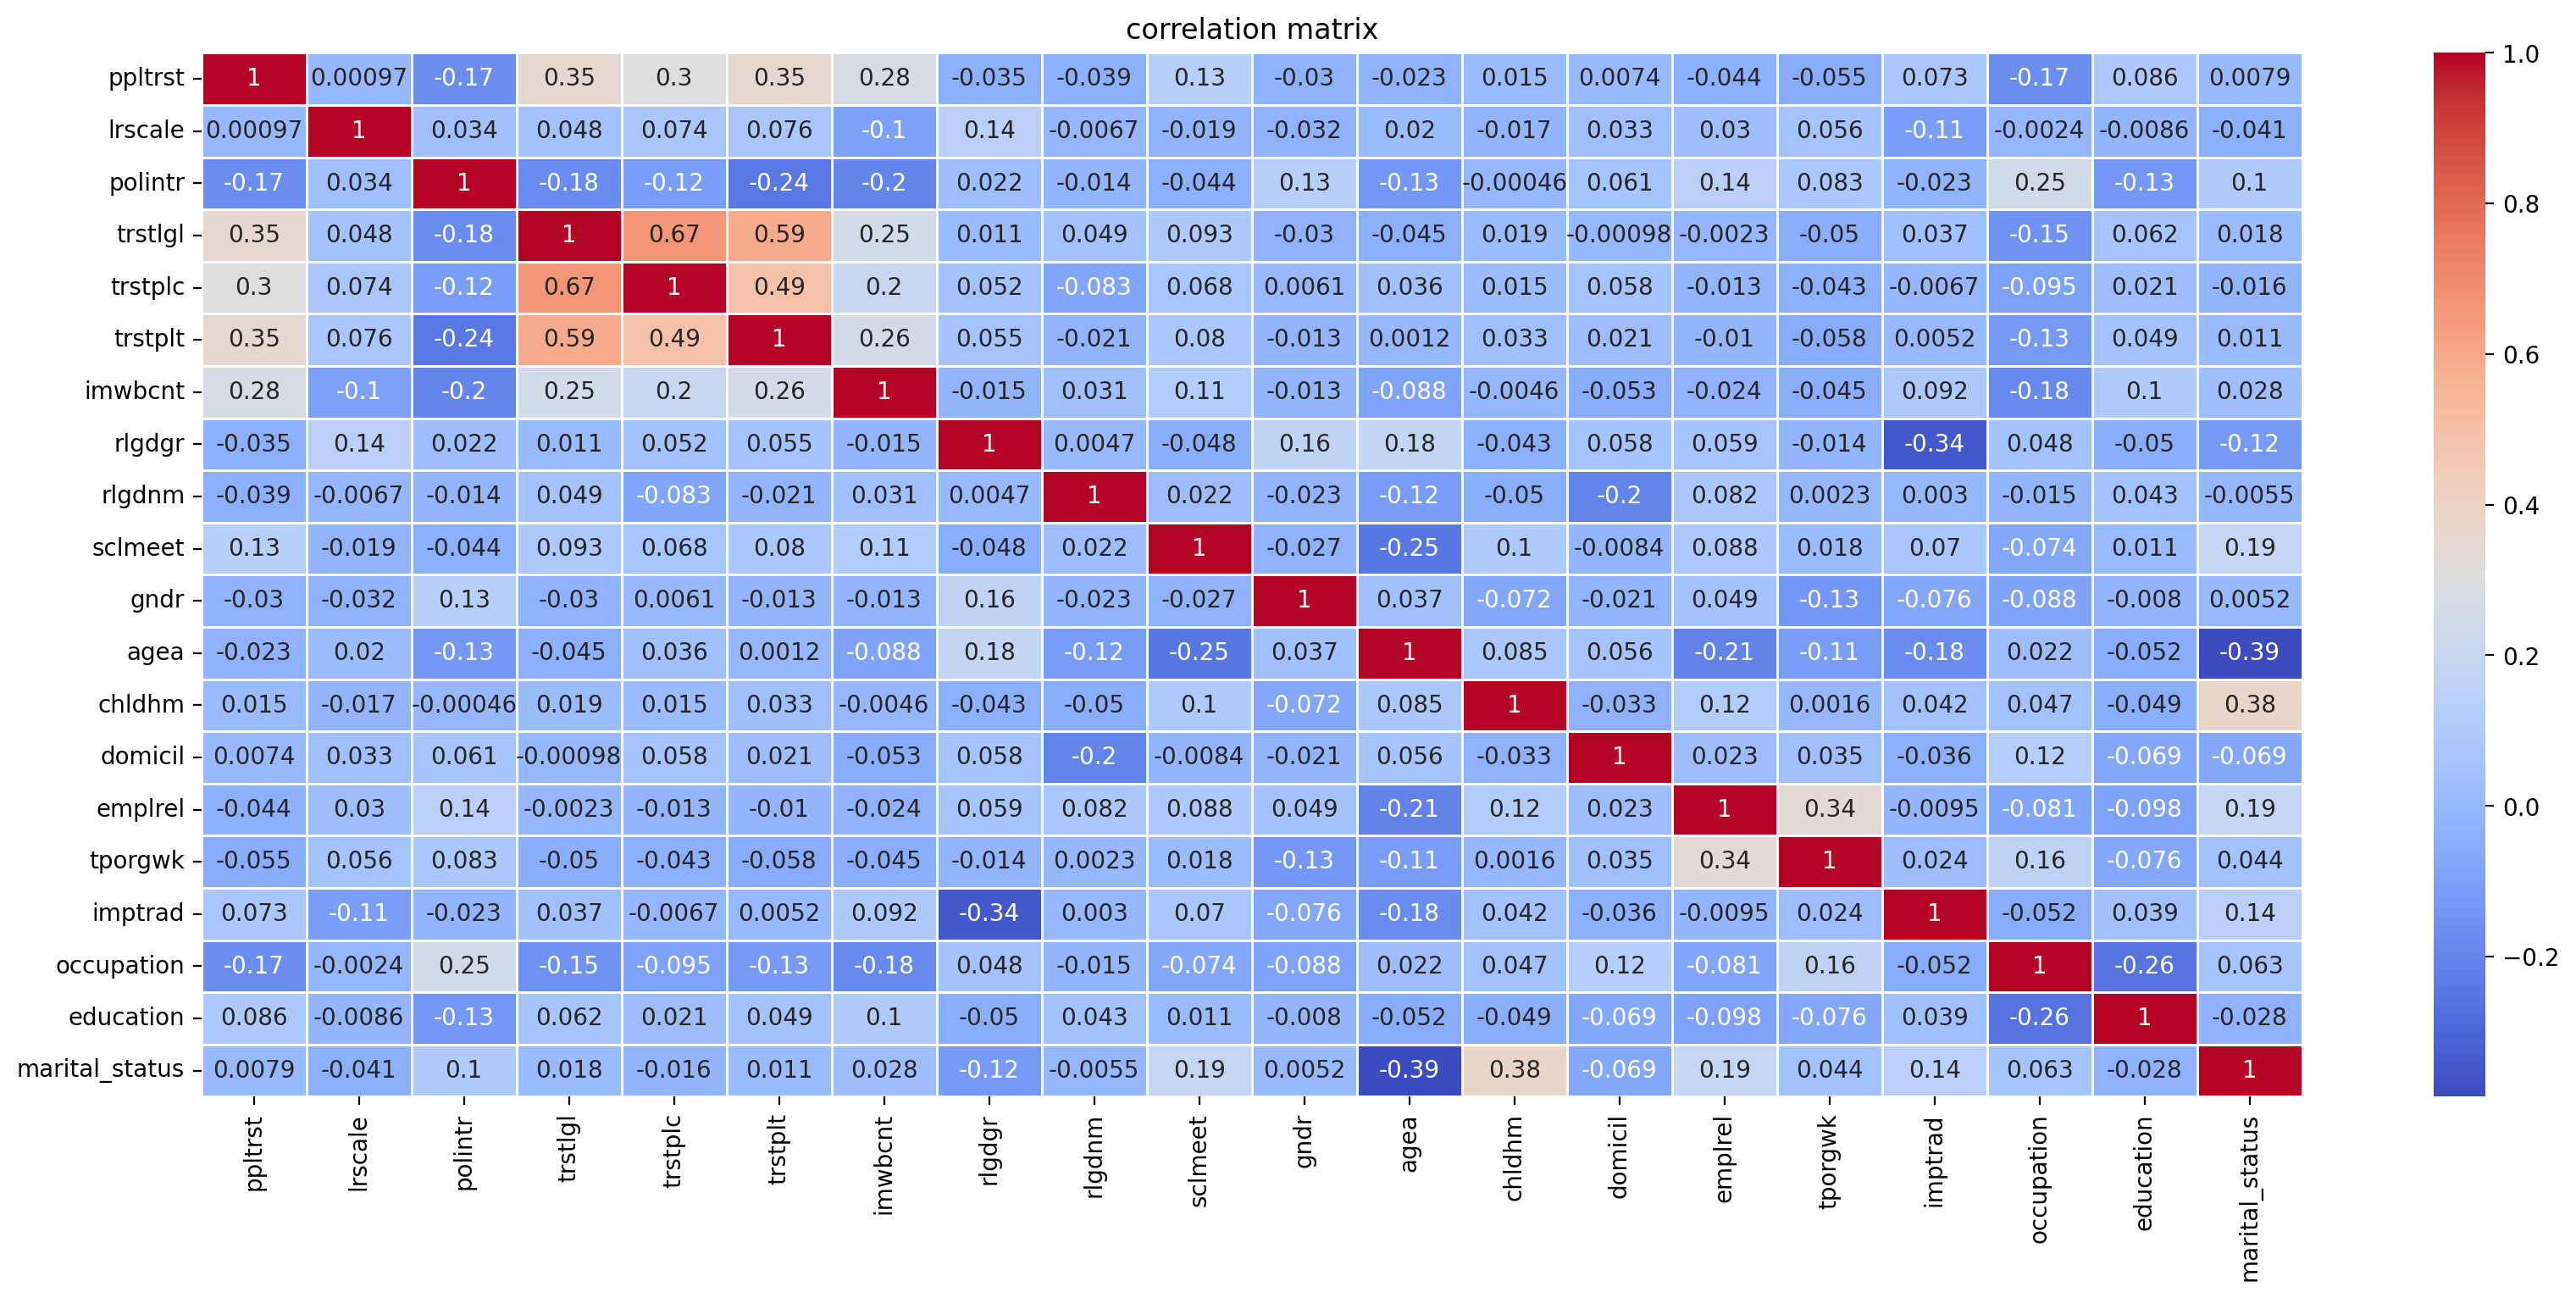

In [59]:
plt.figure(figsize=(20,8))
correlation_matrix = balanced_data.drop('cntry', axis=1).corr()
sns.heatmap(correlation_matrix, annot =True, cmap='coolwarm', linewidths=0.5)
plt.title('correlation matrix')

## Préparation des données d'entrainement

### Séparation des données d'entrainement et de test
Ratio
 - 80 % du dataset pour l'entrainement
 - 20 % du dataset pour les tests

In [60]:
X = balanced_data.drop(label_name, axis=1)
y = balanced_data[label_name]

X_unbalanced = data_enough_values.drop(label_name, axis=1)
y_unbalanced = data_enough_values[label_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X_unbalanced, y_unbalanced, test_size=0.2, random_state=42)

X_train.head()

,cntry,ppltrst,lrscale,polintr,trstlgl,trstplc,trstplt,imwbcnt,rlgdgr,rlgdnm,sclmeet,gndr,agea,chldhm,domicil,emplrel,tporgwk,occupation,education,marital_status
452226,IE,9.0,6.0,2.0,6.0,7.0,6.0,6.0,0.0,NaN,6.0,1.0,36.0,NaN,3.0,1.0,2.0,2,0005,1.0
459979,MK,2.0,NaN,4.0,0.0,0.0,0.0,1.0,10.0,3.0,4.0,2.0,75.0,NaN,4.0,6.0,NaN,NaN,0002,4.0
327532,LT,5.0,2.0,3.0,3.0,3.0,2.0,4.0,6.0,1.0,2.0,2.0,75.0,2.0,4.0,1.0,3.0,5,0004,1.0
243401,BE,7.0,7.0,2.0,4.0,7.0,1.0,4.0,0.0,NaN,5.0,1.0,47.0,1.0,4.0,1.0,4.0,3,0004,1.0
204186,EE,4.0,5.0,4.0,8.0,9.0,2.0,5.0,7.0,NaN,5.0,2.0,46.0,2.0,3.0,2.0,4.0,5,0003,1.0


### Création d'un pipeline de préprocessing de données
- Imputation
  - Imputation par la valeur la plus fréquente pour toutes les features
- Encodage des données catégorielles
  - Les données catégorielles et le label sont déjà encodés. Il n'y a pas de traitement à réaliser
- Normalisation
  - Normalisation "robuste" des features pour isoler les outliers

In [64]:
cntry_col = 'cntry'
categorical_cols = X.drop(numerical_cols, axis=1).drop(cntry_col, axis=1).columns


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

cntry_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
])

# Pipeline pour les données numériques (Standardisation)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Preprocessing complet avec ColumnTransformer
pipeline_preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('cntry', cntry_transformer, [cntry_col])
    ],
    remainder='passthrough')

X_train_scaled = pipeline_preprocessing.fit_transform(X_train)
X_train_unbalanced_scaled = pipeline_preprocessing.fit_transform(X_train_unbalanced)

X_test_scaled = pipeline_preprocessing.transform(X_test)
X_test_unbalanced_scaled = pipeline_preprocessing.transform(X_test_unbalanced)



## Choix du modèle

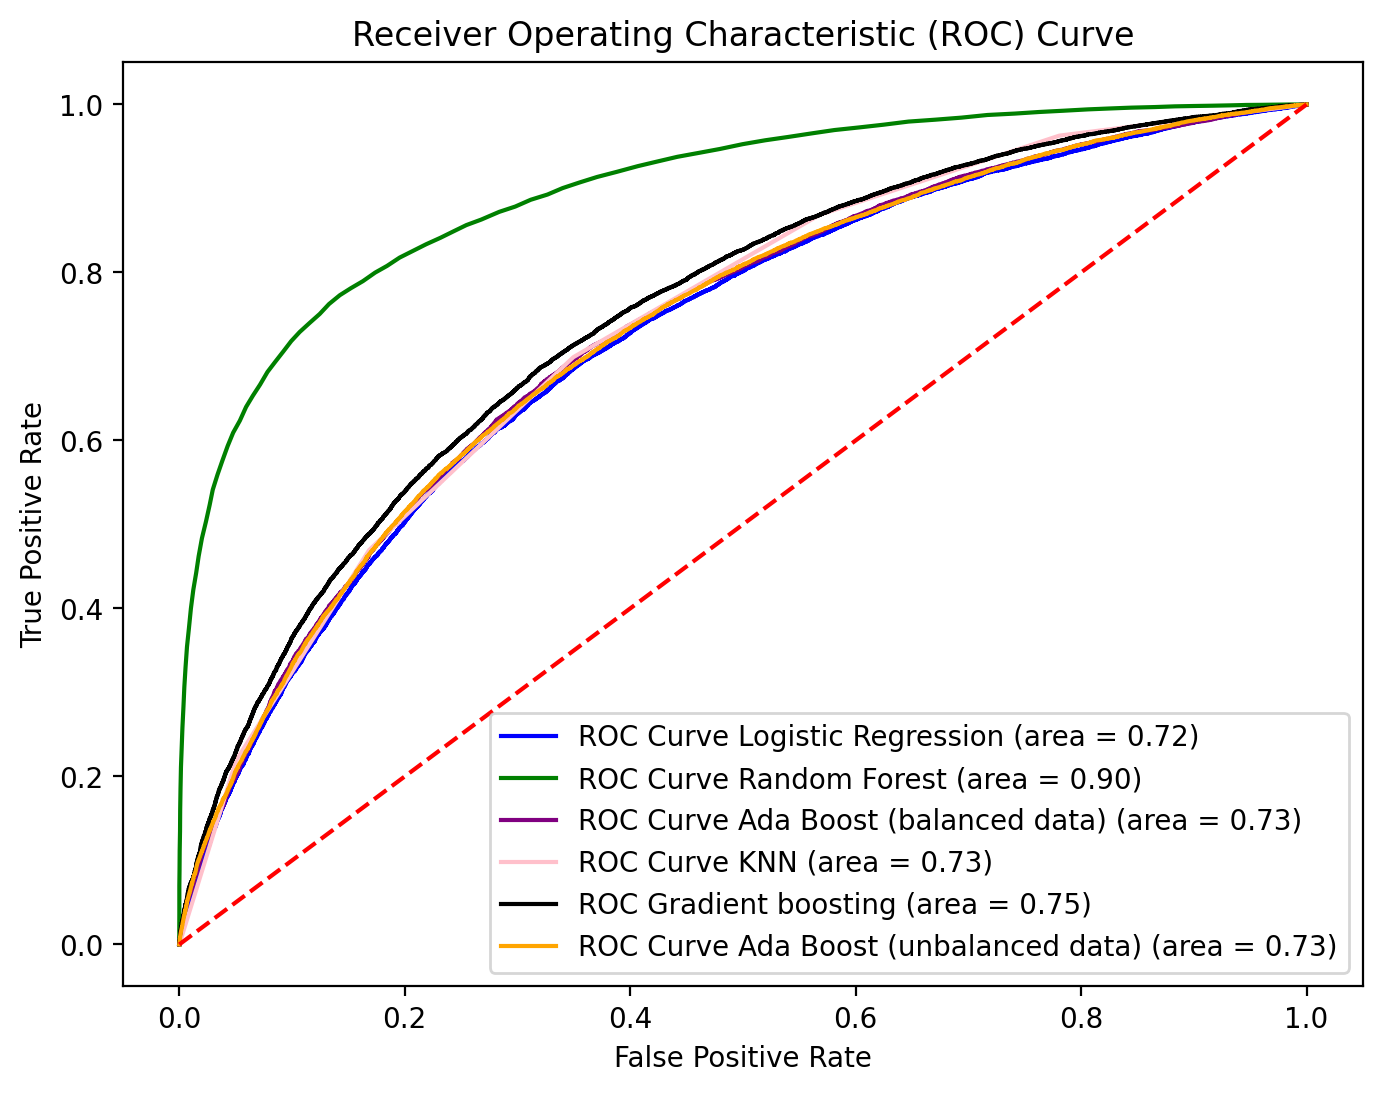

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import ClassifierMixin


def display_roc_curve_for_model(model : ClassifierMixin, X_test: pd.DataFrame, y_test: pd.DataFrame, label: str, color: str) -> list:
    # ROC Curve
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba, pos_label=1)
    plt.plot(fpr, tpr, color=color, label='{0} (area = {1:.2f})'.format(label, roc_auc_score(y_test, proba)))


def display_roc_curves(parameters: list):
    plt.figure(figsize=(8, 6))
    for model, X_test, y_test, label, color in parameters:
        display_roc_curve_for_model(model, X_test, y_test, label, color)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_rfc = RandomForestClassifier(random_state=42)
model_abc = AdaBoostClassifier(random_state=42)
model_abc_unbalanced = AdaBoostClassifier(random_state=42)
model_knn = KNeighborsClassifier()
model_gbc = GradientBoostingClassifier()

model_lr.fit(X_train_scaled, y_train)
model_rfc.fit(X_train_scaled, y_train)
model_abc.fit(X_train_scaled, y_train)
model_abc_unbalanced.fit(X_train_unbalanced_scaled, y_train_unbalanced)
model_knn.fit(X_train_scaled, y_train)
model_gbc.fit(X_train_scaled, y_train)

parameters = [
    (model_lr, X_test_scaled, y_test, 'ROC Curve Logistic Regression', 'blue'),
    (model_rfc, X_test_scaled, y_test, 'ROC Curve Random Forest', 'green'),
    (model_abc, X_test_scaled, y_test, 'ROC Curve Ada Boost (balanced data)', 'purple'),
    (model_knn, X_test_scaled, y_test, 'ROC Curve KNN', 'pink'),
    (model_gbc, X_test_scaled, y_test, 'ROC Gradient boosting', 'black'),
    (model_abc_unbalanced, X_test_unbalanced_scaled, y_test_unbalanced, 'ROC Curve Ada Boost (unbalanced data)', 'orange'),
]

display_roc_curves(parameters)



Le modèle le plus performant est le modèle de type RandomForest. 

Il n'y pas d'amélioration de la performance avec un modèle AdaBoost sur un dataset plus volumineux mais déséquilibré.

On va chercher la combinaison d'hyper paramètre (autour des paramètres par défaut car les résultat sont déjà bon avec le paramétrage d'apprentissage par défaut) qui permet d'avoir les meilleurs résultats.

### Tunning des hyperparamètres du modèle choisi

In [ ]:
# Estimation du max depth du modèle Random forest précédement entraîné
tree_max_depths = []
for tree in model_rfc.estimators_:
    tree_max_depths.append(tree.tree_.max_depth)

print("Max depths of individual trees:", tree_max_depths)

average_max_depth = sum(tree_max_depths) / len(tree_max_depths)
print(f"Average max depth of trees: {average_max_depth:.2f}")



Max depths of individual trees: [38, 38, 41, 39, 38, 39, 40, 39, 40, 39, 38, 39, 39, 39, 42, 44, 39, 38, 40, 44, 40, 39, 39, 37, 37, 41, 42, 42, 43, 42, 43, 40, 37, 41, 42, 41, 41, 39, 41, 43, 40, 37, 41, 39, 38, 40, 41, 40, 38, 40, 40, 40, 40, 39, 38, 40, 38, 38, 40, 42, 40, 39, 39, 39, 43, 39, 38, 36, 39, 38, 47, 41, 42, 40, 40, 38, 38, 41, 40, 38, 40, 43, 37, 40, 39, 42, 38, 38, 42, 38, 42, 38, 44, 40, 37, 43, 40, 39, 37, 39]
Average max depth of trees: 39.83


In [ ]:
from scipy.stats import randint


param_distributions = {
    'n_estimators': randint(90, 110),
    'max_depth': randint(30, 50),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=model_rfc,
    param_distributions=param_distributions,
    n_iter=1, 
    cv=5,      
    verbose=1,  # Print progress messages
    random_state=42,
    scoring='accuracy', 
    n_jobs=-1
)
# Entraînement du modèle avec GridSearch
random_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
print("\nMeilleurs hyperparamètres trouvés:")
print(random_search.best_params_)

# Meilleur score
print(f"Meilleur score de validation: {random_search.best_score_:.2%}")
# Entraînement du modèle avec les meilleurs hyperparamètres
best_model = random_search.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits

Meilleurs hyperparamètres trouvés:
{'bootstrap': True, 'max_depth': 49, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Meilleur score de validation: 78.26%


### Evaluation du modèle

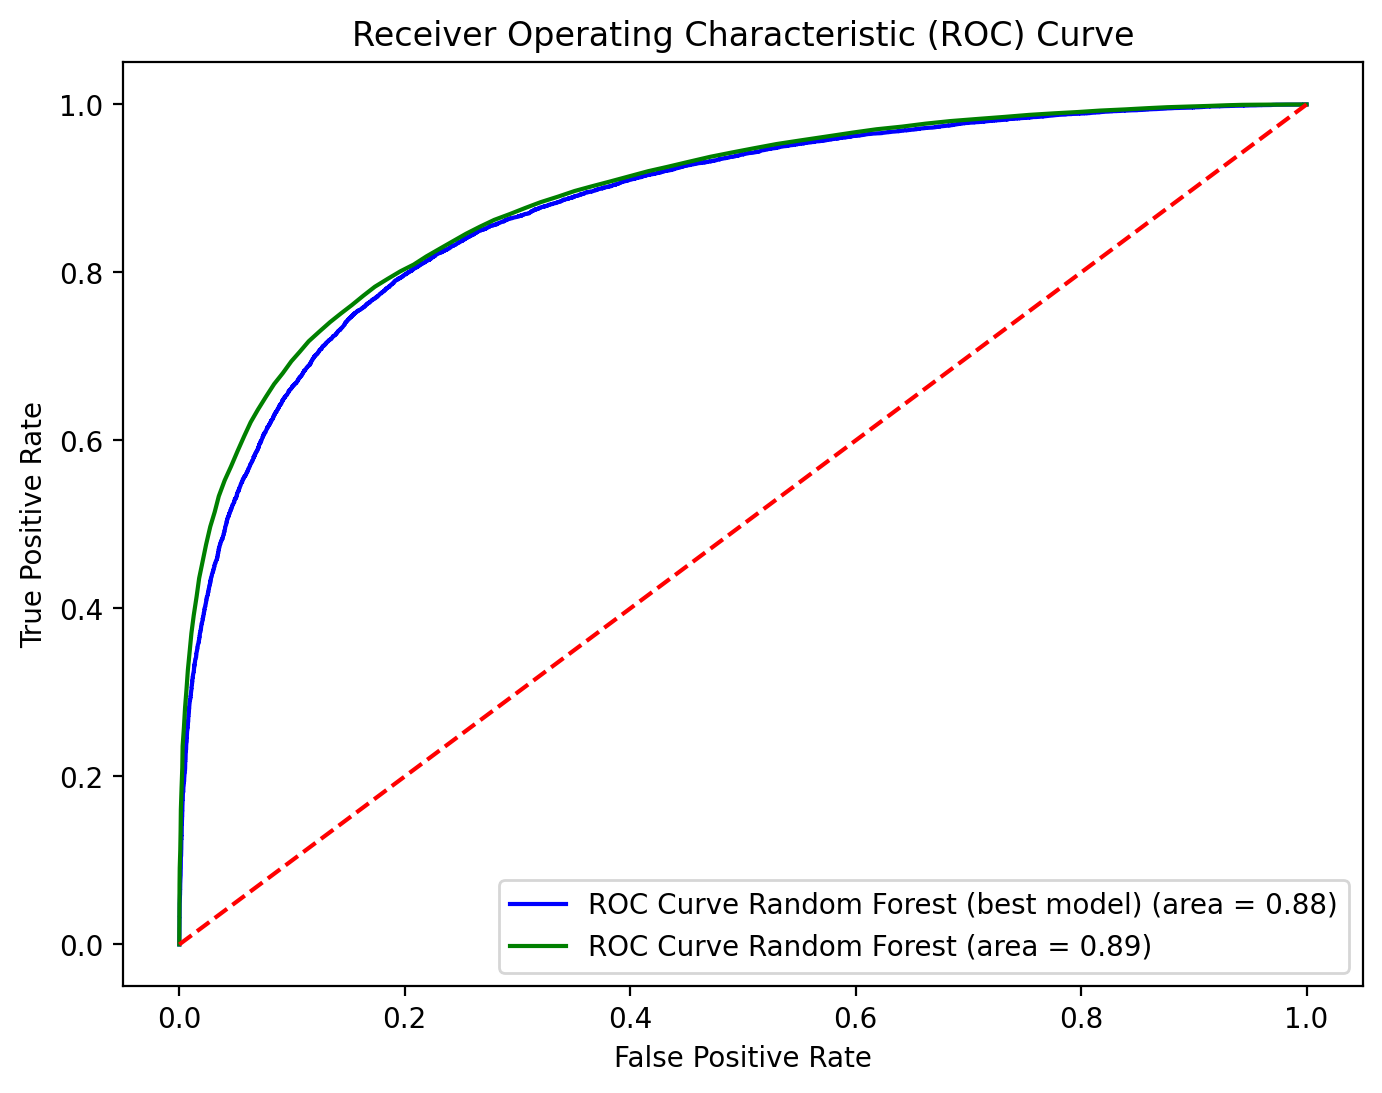

In [ ]:
# Evaluation de l'effet du tunning d'hyperparamètres
parameters_rfc = [
    (best_model, X_test_scaled, y_test, 'ROC Curve Random Forest (best model)', 'blue'),
    (model_rfc, X_test_scaled, y_test, 'ROC Curve Random Forest', 'green')
]

best_model.fit(X_train_scaled, y_train)

display_roc_curves(parameters_rfc)

              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79     23007
         1.0       0.79      0.81      0.80     23333

    accuracy                           0.80     46340
   macro avg       0.80      0.80      0.80     46340
weighted avg       0.80      0.80      0.80     46340

Accuracy Train: 0.9990
Accuracy Test: 0.7978


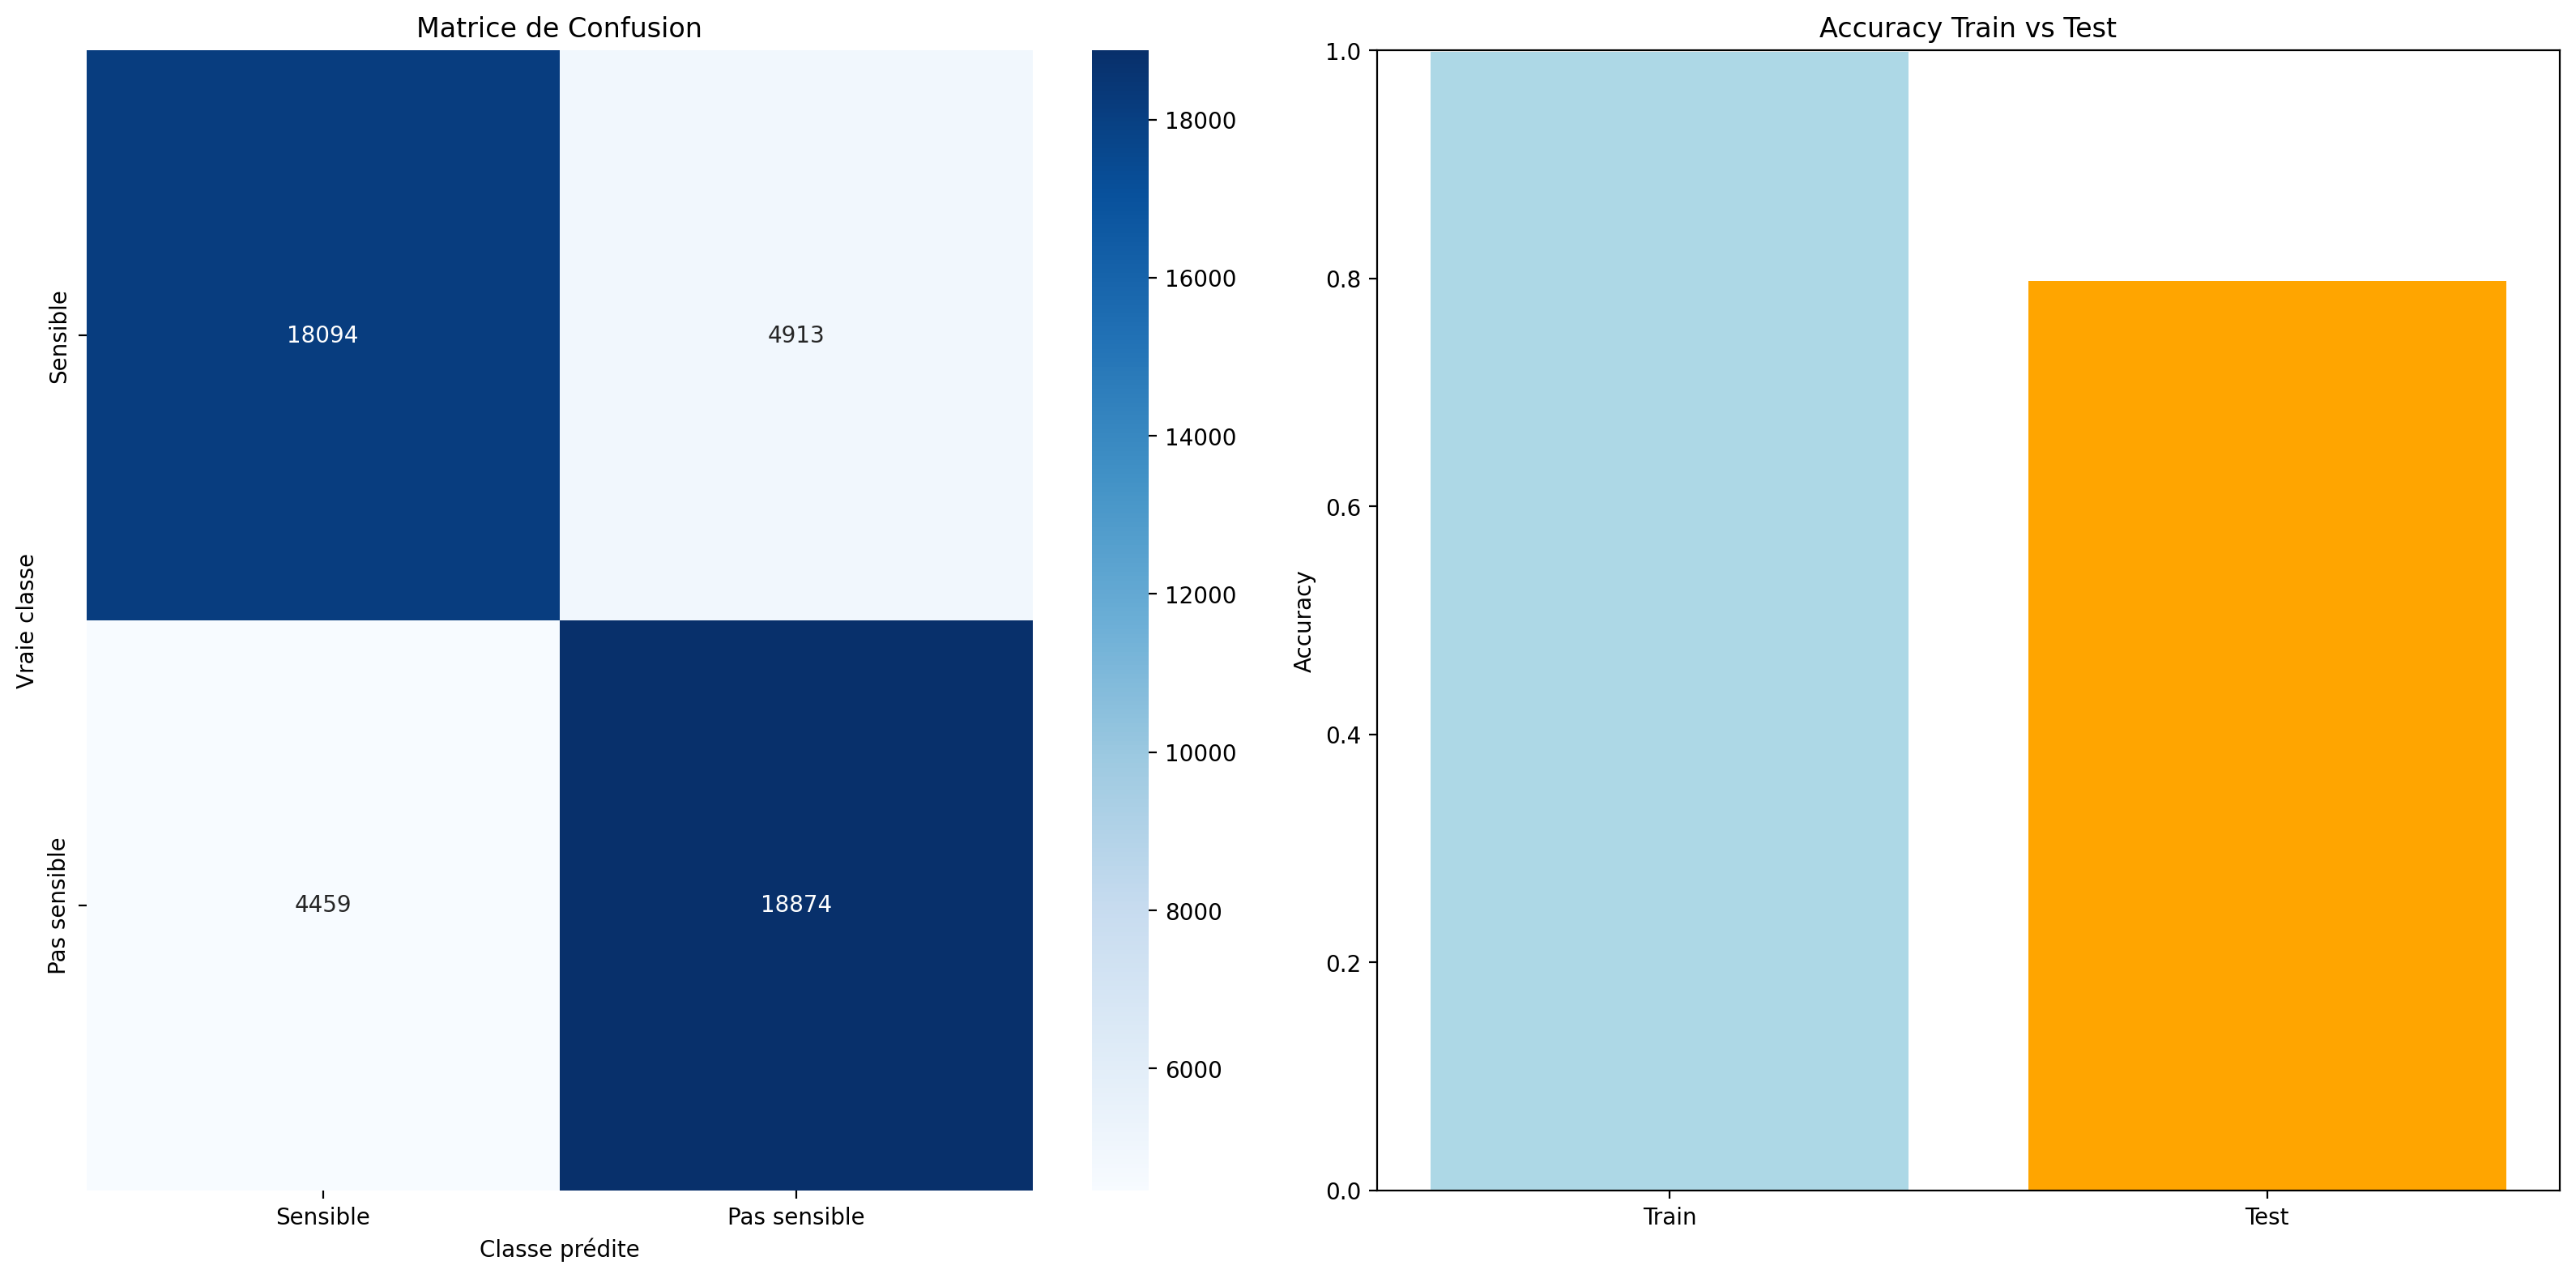

In [ ]:

y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test,y_test_pred)

#texte de rapport rapport plus precis de ce qu'on trouve
print(classification_report(y_test,y_test_pred))

train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

print(f"Accuracy Train: {train_accuracy:.4f}")
print(f"Accuracy Test: {test_accuracy:.4f}")

# Display Confusion Matrix
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sensible', 'Pas sensible'],
            yticklabels=['Sensible', 'Pas sensible'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')

plt.subplot(1, 2, 2)
scores = [train_accuracy, test_accuracy]
labels = ['Train', 'Test']
colors = ['lightblue', 'orange']
plt.bar(labels, scores, color=colors)
plt.title('Accuracy Train vs Test')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()
